In [28]:
!pip3 install igraph

import os
import pickle
import collections
import json

import numpy as np
import pandas as pd
from datetime import datetime
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import seaborn as sns

import networkx as nx
import igraph as ig

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
def cubic_smooth_series(s, step=7):
    x_min = 0
    x_max = len(s)
    x = np.arange(x_min, x_max, step=step)
    y = s[::step].to_numpy()
    f = interpolate.CubicSpline(x,y)
    x = np.arange(x_min, x_max, step=1)
    y_smoothed = f(x)
    s_ret = pd.Series(y_smoothed)
    s_ret = s_ret.rename(lambda x: s.index[x])
    return s_ret

def first_derivative(s):
    y = s.to_numpy()
    y_p_h = np.append(y[0], y[:-1])
    
    y_der = pd.Series(y_p_h - y)
    y_der = y_der.rename(lambda x: s.index[x])
    return y_der

def second_derivative(s):
    y = s.to_numpy()
    y_p_h = np.append(y[0], y[:-1])
    y_m_h = np.append(y[1:], y[-1])
    
    y_second_der = pd.Series(y_p_h - 2*y + y_m_h)
    y_second_der = y_second_der.rename(lambda x: s.index[x])
    return y_second_der

def get_peak_dict_annot(temp, province):
    m_idx = np.argmax(temp['nuovi_positivi'])
    date = temp.iloc[m_idx,1]
    val = np.max(temp['nuovi_positivi'])
    return {'annot': 'Peak '+ province, 'date': date, 'val': val}

def get_start_outbreak_dict_annot(temp, province):
    m_idx = np.argmax(temp['nuovi_positivi'])
    max_peak_date = temp.iloc[m_idx]['data']
    idx_outbreak = np.where(temp['data'] <= max_peak_date)
    max_second_derivative_index = temp.iloc[(idx_outbreak[0][2:-10])]['acc_nuovi_positivi'].idxmax()
    val = temp.loc[max_second_derivative_index]['nuovi_positivi']
    date = temp.loc[max_second_derivative_index]['data']
    return {'annot': 'Start '+ province, 'date': date, 'val': val}


In [13]:
def tile_to_center(tile, ntilex, ntiley, tile_x=1000, tile_y=1000):
    tile_x_id = np.mod(tile, ntilex)
    tile_y_id = np.floor(tile/ntilex)
    center_x = (tile_x_id + 0.5) * tile_x
    center_y = (tile_y_id + 0.5) * tile_y
    return (center_x, center_y)

In [14]:
def harmonic_centrality(df_pos_province, tile_x = 1000, gamma=-1):
    ret_array = []
    N = len(df_pos_province)
    tiles = df_pos_province.tile_id.unique()
    tile_data = {}
    for tile in tiles:
        tile_data[tile] = {}
        df = df_pos_province[df_pos_province['tile_id'] == tile]
        tile_data[tile]['N_tile'], _ = df.shape
        if(len(df['x'].unique()) != len(df['y'].unique()) != 1):
            raise Exception(f"Tile {tile} is not uniquely defined in space.")
        tile_data[tile]['x_tile'], tile_data[tile]['y_tile'] = df['x'].unique()[0], df['y'].unique()[0]
        HC = {}
    for tile_i in tiles:
        HC[tile_i] = 0
        for tile_j in tiles:
            dx = tile_data[tile_i]['x_tile'] - tile_data[tile_j]['x_tile']
            dy = tile_data[tile_i]['y_tile'] - tile_data[tile_j]['y_tile']
            dist_ij = np.sqrt(dx*dx + dy*dy)
            dist_ij = max(dist_ij, tile_x*0.5)
            HC_ij = np.power(dist_ij,gamma)
            N_i = tile_data[tile_i]['N_tile']
            N_j = tile_data[tile_j]['N_tile']
            if(tile_i == tile_j): HC_ij = HC_ij*(N_j - 1)/N
            else: HC_ij = HC_ij*N_j/N
            HC[tile_i] = HC[tile_i]+HC_ij
    tiles = df_pos_province['tile_id']
    HC = [HC[tile] for tile in tiles]
    
    return HC

def harmonic_centrality_for_all(df_pos_province, tile_x = 1000, gamma=-1):
    ret_array = []
    for row in df_pos_province.iterrows():
        index = row[0]
        df = df_pos_province.drop(index)
        x_v, y_v = row[1]['x'], row[1]['y']
        dx_u, dy_u = x_v - df['x'], y_v - df['y']
        dist_v = np.sqrt(dx_u*dx_u + dy_u*dy_u)
        low_cut = np.vectorize(lambda x: max(x, tile_x * 0.5))
        dist_v = low_cut(dist_v)
        N = len(df) + 1
        HC_v = np.sum(np.power(dist_v,gamma))*1/N
        ret_array.append(HC_v)
    return ret_array

In [25]:
usn_dict_path = 'province_hc_graph_usn.pickle'
er_dict_path = 'province_hc_graph_er.pickle'

with open(usn_dict_path, "rb") as f:
  usn_dict = pickle.load(f)

with open(er_dict_path, "rb") as f:
  er_dict = pickle.load(f)

if sorted(er_dict.keys()) == sorted(usn_dict.keys()):
  print('True')
  province_hc_dict = {}
  for province in er_dict:
    province_hc_dict[province] = {}
    province_hc_dict[province]['hc_er_mean'] = er_dict[province]['hc_mean']
    province_hc_dict[province]['hc_er_std'] = er_dict[province]['hc_std']
    province_hc_dict[province]['hc_usn_mean'] = usn_dict[province]['hc_graph']
    province_hc_dict[province]['hc_usn_std'] = usn_dict[province]['hc_graph']*0.2

with open('province_hc.pickle', 'wb') as f:
  pickle.dump(province_hc_dict, f)

True


In [87]:
istat_pop_df = pd.read_csv('DCIS_POPRES1_22112022112900856.csv')
istat_pop_df = istat_pop_df.set_index('Territorio').loc[provinces].reset_index().groupby('Territorio').sum()['Value'].reset_index()

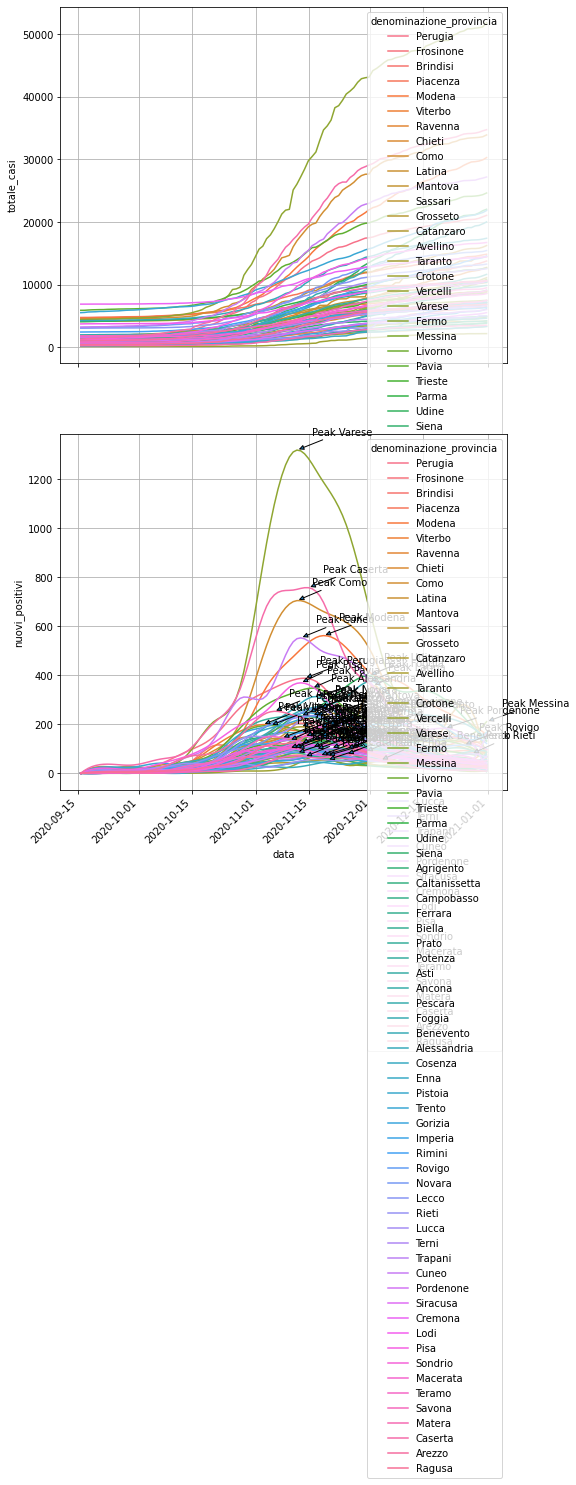

In [89]:
url_dpc_province = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv"
fields_dpc_province = ['data', 'denominazione_regione', 'denominazione_provincia', 'totale_casi']
df_pr=pd.read_csv(url_dpc_province, parse_dates=['data'], usecols=fields_dpc_province)

provinces = [p for p in province_hc_dict.keys()]

istat_pop_df = pd.read_csv('DCIS_POPRES1_22112022112900856.csv')
istat_pop_df = istat_pop_df.set_index('Territorio').loc[provinces].reset_index().groupby('Territorio').sum()['Value'].reset_index()

# Check for provinces
rem_prov = []
for province in provinces:
    if(len(df_pr[df_pr['denominazione_provincia'] == province]) == 0):
        print(province+" not found in DPC dataset")
        rem_prov.append(province)

    if(len(istat_pop_df[istat_pop_df['Territorio'] == province]) == 0):
        print(province+" not found in ISTAT dataset")
        rem_prov.append(province)

for province in rem_prov:
    provinces.remove(province)

province_peak = {}

#Draw the plot
fig, ax = plt.subplots(2,1,figsize=(8,16))

start_date = datetime(2020,9,15)
end_date = datetime(2021,1,1)
#Query cities and dates
plot_df = []
for province in provinces:
    idx = np.where(
        (df_pr['data'] >= start_date) & 
        (df_pr['data'] <= end_date) & 
        (df_pr['denominazione_provincia'] == province)
    )
    temp = df_pr.iloc[idx]
    if(len(temp) == 0):
        print(province+" not found")
        provinces.remove(province)
        continue
    province_peak[province] = {}
    temp.insert(0, 'nuovi_positivi', cubic_smooth_series(temp['totale_casi'].diff().ewm(span = 7).mean().fillna(0)))
    province_peak[province]['peak'] = get_peak_dict_annot(temp, province)
    N_province = int(istat_pop_df[istat_pop_df['Territorio'] == province].Value.values[0])
    province_peak[province]['N_province'] = N_province
    val = province_peak[province]['peak']['val']/N_province
    province_peak[province]['peak']['peak_frac'] = val

    plot_df.append(temp[['data', 'totale_casi', 'nuovi_positivi', 'denominazione_provincia']])
plot_df = pd.concat(df for df in plot_df)
sns.lineplot(data=plot_df, x='data', y='totale_casi', hue='denominazione_provincia', ax=ax[0])
sns.lineplot(data=plot_df, x='data', y='nuovi_positivi', hue='denominazione_provincia', ax=ax[1])

fig.autofmt_xdate(rotation=45)
for a in ax:
    a.grid()

for province in province_peak:
    ax[1].annotate(
        province_peak[province]['peak']['annot'],
        (mdates.date2num(province_peak[province]['peak']['date']),
         province_peak[province]['peak']['val']),
        xytext=(15, 15), 
            textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))

In [ ]:
path_to_file = "./province_hc.pickle"

with open(path_to_file, "rb") as f:
    province_hc = pickle.load(f)
        
x_usn = []
x_er = []
y = []
annot = []

for province in provinces:
    N = province_peak[province]['N_province']
    peak_frac = province_peak[province]['peak']['peak_frac']
    y.append(peak_frac)
    annot.append(province)

for province in provinces:
  x_usn.append(province_hc[province]['hc_usn_mean'])
  x_er.append(province_hc[province]['hc_er_mean'])

print("Harmonic cetrality (USN graph) Pearson correlation with peak fraction (DPC data):")
print(np.corrcoef(x_usn, y))
fig, ax = plt.subplots(figsize=(16,12))
ax.scatter(x_usn, y, color='blue')
for i, txt in enumerate(annot):
    ax.annotate(txt, (x_usn[i], y[i]))

ax.set_xlabel('Harmonic Centrality')
ax.set_ylabel('Peak Fraction')
ax.set_title('Peak Fraction (DPC) vs. USN harmonic centrality')
ax.grid()

fig.savefig("peak_fraction_hc_usn.png")

print("Harmonic cetrality (ER graph) Pearson correlation with peak fraction (DPC data):")
print(np.corrcoef(x_er, y))
fig, ax = plt.subplots(figsize=(16,12))
ax.scatter(x_usn, y, color='red')
for i, txt in enumerate(annot):
    ax.annotate(txt, (x_usn[i], y[i]))

ax.set_xlabel('Harmonic Centrality')
ax.set_ylabel('Peak Fraction')
ax.set_title('Peak Fraction (DPC) vs. ER harmonic centrality')
ax.grid()

fig.savefig("peak_fraction_hc_er.png")

print("Harmonic cetrality Pearson correlation (ER graph and USN grap):")
print(np.corrcoef(x_er, x_usn))

fig, ax = plt.subplots(figsize=(16,12))
ax.scatter(x_usn, y, color='blue', label='Urban Social Network')
for i, txt in enumerate(annot):
    ax.annotate(txt, (x_usn[i], y[i]))

ax.scatter(x_er, y, color='red', label='Erdos Renyi')
for i, txt in enumerate(annot):
    ax.annotate(txt, (x_er[i], y[i]))

ax.set_xlabel('Harmonic Centrality')
ax.set_ylabel('Peak Fraction')
ax.set_title('Peak Fraction (DPC) vs. Harmonic centrality')
ax.grid()
fig.savefig("peak_fraction_hc_all.png")


R^2: [-0.05648544  0.03822654 -0.17821252 -0.02866563 -0.40409743]
Mean squared error:  [1.77133925e-09 3.50222064e-09 2.62275074e-09 7.09240586e-09
 2.29832483e-09]


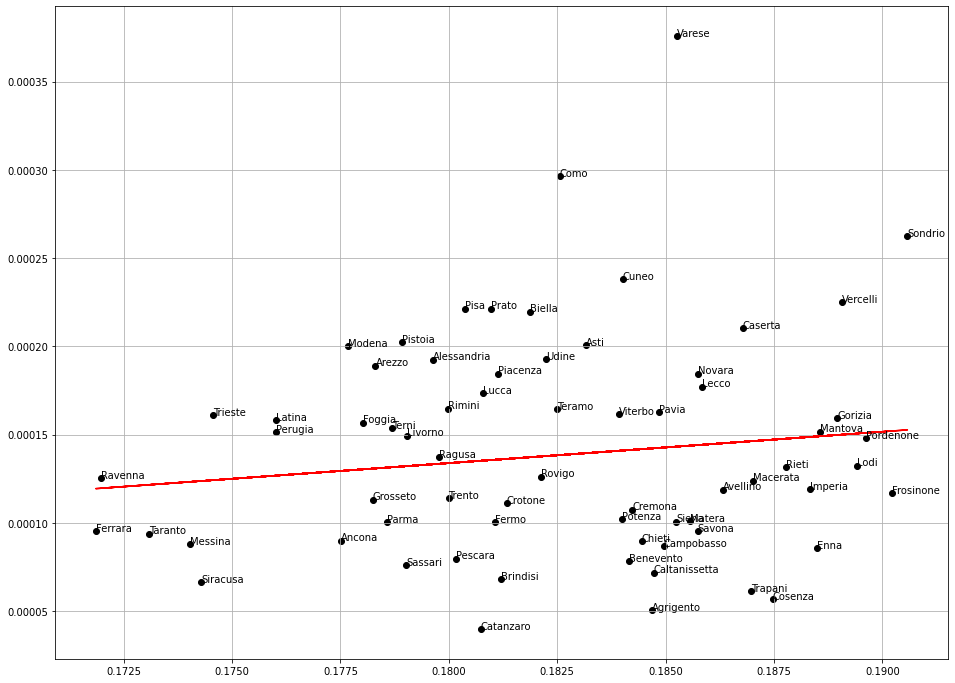

In [92]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

X = np.array(x_usn).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

cf = LinearRegression()
cf.fit(X_train, y_train)

y_pred = cf.predict(X)

fig, ax = plt.subplots(figsize=(16,12))
x_plot = []
y_plot = []
annot = []
for province in provinces:
    x_plot.append(province_hc[province]['hc_usn_mean'])
    y_plot.append(province_peak[province]['peak']['peak_frac'])
    annot.append(province)

ax.scatter(x_plot, y_plot, color='black')
for i, txt in enumerate(annot):
    ax.annotate(txt, (x_plot[i], y_plot[i]))

ax.plot(X, y_pred, color="red")
ax.grid()

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
      
print("R^2:",scores)
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
print("Mean squared error: ", -scores)
fig.savefig("peak_fraction_hc_usn_pred.png")

R^2: [-0.09517038 -0.04718161 -0.01890277 -0.15697318 -0.59010201]
Mean squared error:  [1.70822229e-09 3.16283112e-09 3.02070265e-09 6.26264432e-09
 1.93885802e-09]


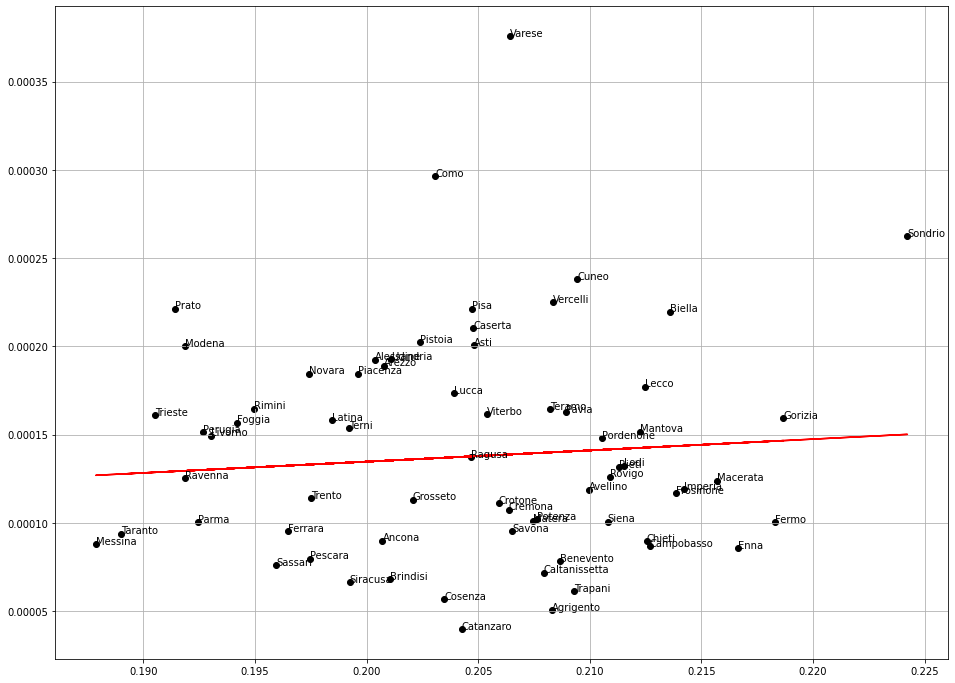

In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

X = np.array(x_er).reshape(-1, 1)
y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

cf = LinearRegression()
cf.fit(X_train, y_train)

y_pred = cf.predict(X)

fig, ax = plt.subplots(figsize=(16,12))
x_plot = []
y_plot = []
annot = []
for province in provinces:
    x_plot.append(province_hc[province]['hc_er_mean'])
    y_plot.append(province_peak[province]['peak']['peak_frac'])
    annot.append(province)

ax.scatter(x_plot, y_plot, color='black')
for i, txt in enumerate(annot):
    ax.annotate(txt, (x_plot[i], y_plot[i]))

ax.plot(X, y_pred, color="red")
ax.grid()

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

lm = LinearRegression()
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=5)
      
print("R^2:",scores)
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
print("Mean squared error: ", -scores)
fig.savefig("peak_fraction_hc_er_pred.png")